# 7:3 Train/Test Ratio

In [1]:
# import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
# read data
df = pd.read_csv('BIDV.csv')
df = df[['Price','Open','High']]

In [3]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbos

,Price_x,Open_x,High_x
Price_y,1.0,0.0002,0.0
Open_y,0.0,1.0000,0.0
High_y,0.0,0.0000,1.0


In [4]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  515.39    > 24.2761   =>   True
Open   ::  134.98    > 12.3212   =>   True
High   ::  0.12      > 4.1296    =>   False


In [5]:
df =  df[['Price','Open']]

In [6]:
# check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -1.199824
p-value: 0.673672




In [7]:
# differencing
from statsmodels.tsa.stattools import adfuller
df_difference = df.diff().dropna()
adf1 = adfuller(df_difference['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -51.369229
p-value: 0.000000




In [8]:
# Split train/test
train_size = int(0.3 * len(df))
train = df_difference[:-train_size]
test = df_difference[-train_size:]

In [9]:
# find the best fit model
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  24.167456824646585
BIC:  24.18638787780685

Order = 2
AIC:  23.983758126068988
BIC:  24.015324792442623

Order = 3
AIC:  23.85297337816792
BIC:  23.897187608100783

Order = 4
AIC:  23.790355478763118
BIC:  23.847229241039816

Order = 5
AIC:  23.75348700284551
BIC:  23.823032284728548

Order = 6
AIC:  23.719055326168654
BIC:  23.801284133437687

Order = 7
AIC:  23.704032641427634
BIC:  23.798956998418834

Order = 8
AIC:  23.667566783060895
BIC:  23.77519873270641

Order = 9
AIC:  23.661592967236114
BIC:  23.781944571103654

Order = 10
AIC:  23.65262125346848
BIC:  23.78570459180099



C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored 

In [10]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,25.34,25.35,1.011e+11,25.34
1,24.18,24.20,3.168e+10,24.19
2,23.99,24.03,2.635e+10,24.01
3,23.86,23.91,2.310e+10,23.88
4,23.80,23.86,2.167e+10,23.82
5,23.76,23.83,2.087e+10,23.79
6,23.73,23.81,2.014e+10,23.76
7,23.71,23.80,1.982e+10,23.74
8,23.67,23.78*,1.908e+10,23.71
9,23.67,23.79,1.895e+10,23.71


In [11]:
result = model.fit(8)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     00:53:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    23.7752
Nobs:                     1722.00    HQIC:                   23.7074
Log likelihood:          -25230.6    FPE:                1.89974e+10
AIC:                      23.6676    Det(Omega_mle):     1.86278e+10
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           15.834962        12.392881            1.278           0.201
L1.Price        -0.017026         0.025746           -0.661           0.508
L1.Open          0.104843         0.045735            2.292           0.022
L2.P

In [12]:
# Get the lag order
lag_order = result.k_ar
lagged_Values = train.values[-lag_order:]

# Forecast
pred = result.forecast(y=lagged_Values, steps=len(test)+30) 

idx = pd.RangeIndex(start=len(train), stop=len(df)+29, step=1)
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['price_1d', 'open_1d'])

In [13]:
# Convert differenced values into original values
df_forecast['PriceForecast'] = df['Price'].iloc[-train_size-1] + df_forecast['price_1d'].cumsum()
df_forecast['OpenForecast'] = df['Open'].iloc[-train_size-1] + df_forecast['open_1d'].cumsum()
df_forecast_30 = df_forecast[-30:]
df_forecast = df_forecast[:-30]

In [14]:
# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
test_score_rmse_lstm = np.sqrt(mean_squared_error(df[-train_size:]['Price'], df_forecast['PriceForecast']))
test_score_mape_lstm = mean_absolute_percentage_error(df[-train_size:]['Price'], df_forecast['PriceForecast']) * 100
test_score_msle_lstm = mean_squared_log_error(df[-train_size:]['Price'], df_forecast['PriceForecast'])

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 6386.942559129581
MAPE trên tập test là: 15.203541982372428
MSLE trên tập test là: 0.027009330271389808


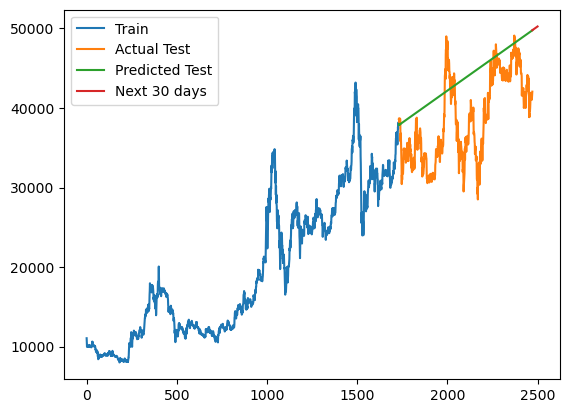

In [92]:
# Plot
plt.plot(df[:-train_size].index, df[:-train_size]['Price'], label='Train')
plt.plot(test.index, df[-train_size:]['Price'], label='Actual Test')
plt.plot(df[-train_size:].index, df_forecast['PriceForecast'], label='Predicted Test')
plt.plot(df_forecast_30.index, df_forecast_30['PriceForecast'], label='Next 30 days')
plt.legend()
plt.show()

# 8:2 Tran/Test Ratio

In [15]:
# import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [16]:
# read data
df = pd.read_csv('BIDV.csv')
df = df[['Price','Open','High']]

In [17]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbos

,Price_x,Open_x,High_x
Price_y,1.0,0.0002,0.0
Open_y,0.0,1.0000,0.0
High_y,0.0,0.0000,1.0


In [18]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  515.39    > 24.2761   =>   True
Open   ::  134.98    > 12.3212   =>   True
High   ::  0.12      > 4.1296    =>   False


In [19]:
df =  df[['Price','Open']]

In [20]:
# check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -1.199824
p-value: 0.673672




In [21]:
# differencing
from statsmodels.tsa.stattools import adfuller
df_difference = df.diff().dropna()
adf1 = adfuller(df_difference['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -51.369229
p-value: 0.000000




In [22]:
# Split train/test
train_size = int(0.2 * len(df))
train = df_difference[:-train_size]
test = df_difference[-train_size:]

In [23]:
# find the best fit model
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  24.269327426563102
BIC:  24.28629755777254

Order = 2
AIC:  24.09884479126592
BIC:  24.127140101024576

Order = 3
AIC:  23.965956496602615
BIC:  24.00558640596427

Order = 4
AIC:  23.900603820931316
BIC:  23.951577763713075

Order = 5
AIC:  23.861777330703198
BIC:  23.924104753509273

Order = 6
AIC:  23.833862634857717
BIC:  23.907552997103263

Order = 7
AIC:  23.818442792303237
BIC:  23.90350556623824

Order = 8
AIC:  23.793337299341133
BIC:  23.889781970074363

Order = 9
AIC:  23.78930001746777
BIC:  23.89713608299077

Order = 10
AIC:  23.78206911849457
BIC:  23.901306089705724



C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored 

In [24]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,25.48,25.49,1.166e+11,25.48
1,24.28,24.30,3.503e+10,24.29
2,24.11,24.14,2.953e+10,24.12
3,23.97,24.01,2.583e+10,23.99
4,23.91,23.96,2.417e+10,23.93
5,23.87,23.93,2.323e+10,23.89
6,23.84,23.91,2.257e+10,23.87
7,23.82,23.91,2.220e+10,23.85
8,23.80,23.89*,2.163e+10,23.83
9,23.79,23.90,2.152e+10,23.83


In [25]:
result = model.fit(8)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     00:54:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    23.8898
Nobs:                     1969.00    HQIC:                   23.8288
Log likelihood:          -28978.3    FPE:                2.15435e+10
AIC:                      23.7933    Det(Omega_mle):     2.11762e+10
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           12.531187        12.142758            1.032           0.302
L1.Price        -0.002170         0.024018           -0.090           0.928
L1.Open          0.094319         0.044349            2.127           0.033
L2.P

In [26]:
# Get the lag order
lag_order = result.k_ar
lagged_Values = train.values[-lag_order:]

# Forecast
pred = result.forecast(y=lagged_Values, steps=len(test)+30) 

idx = pd.RangeIndex(start=len(train), stop=len(df)+29, step=1)
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['price_1d', 'open_1d'])

In [27]:
# Convert differenced values into original values
df_forecast['PriceForecast'] = df['Price'].iloc[-train_size-1] + df_forecast['price_1d'].cumsum()
df_forecast['OpenForecast'] = df['Open'].iloc[-train_size-1] + df_forecast['open_1d'].cumsum()
df_forecast_30 = df_forecast[-30:]
df_forecast = df_forecast[:-30]

In [28]:
# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
test_score_rmse_lstm = np.sqrt(mean_squared_error(df[-train_size:]['Price'], df_forecast['PriceForecast']))
test_score_mape_lstm = mean_absolute_percentage_error(df[-train_size:]['Price'], df_forecast['PriceForecast']) * 100
test_score_msle_lstm = mean_squared_log_error(df[-train_size:]['Price'], df_forecast['PriceForecast'])

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 4998.594276858441
MAPE trên tập test là: 9.926849269500888
MSLE trên tập test là: 0.015354713752271789


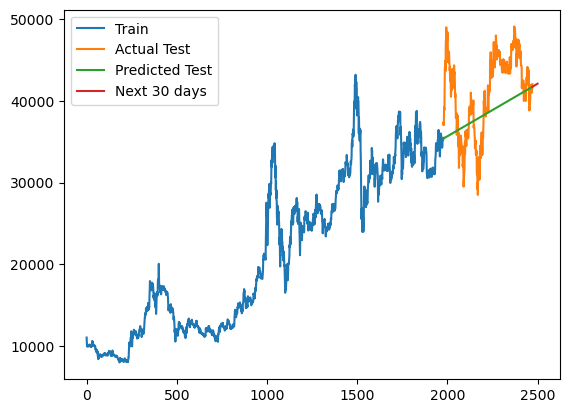

In [29]:
# Plot
plt.plot(df[:-train_size].index, df[:-train_size]['Price'], label='Train')
plt.plot(test.index, df[-train_size:]['Price'], label='Actual Test')
plt.plot(df[-train_size:].index, df_forecast['PriceForecast'], label='Predicted Test')
plt.plot(df_forecast_30.index, df_forecast_30['PriceForecast'], label='Next 30 days')
plt.legend()
plt.show()

# 9:1 Train/Test Ratio

In [30]:
# import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

#read data
df = pd.read_csv('BIDV.csv')
df = df[['Price','Open','High']]

In [31]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbos

,Price_x,Open_x,High_x
Price_y,1.0,0.0002,0.0
Open_y,0.0,1.0000,0.0
High_y,0.0,0.0000,1.0


In [32]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  515.39    > 24.2761   =>   True
Open   ::  134.98    > 12.3212   =>   True
High   ::  0.12      > 4.1296    =>   False


In [33]:
df =  df[['Price','Open']]

In [34]:
# check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -1.199824
p-value: 0.673672




In [35]:
# differencing
from statsmodels.tsa.stattools import adfuller
df_difference = df.diff().dropna()
adf1 = adfuller(df_difference['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -51.369229
p-value: 0.000000




In [36]:
# Split train/test
train_size = int(0.1 * len(df))
train = df_difference[:-train_size]
test = df_difference[-train_size:]

In [37]:
# find the best fit model
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  24.64810569908363
BIC:  24.66350816308893

Order = 2
AIC:  24.476278984471968
BIC:  24.501959285868008

Order = 3
AIC:  24.375974772862225
BIC:  24.411940544827342

Order = 4
AIC:  24.285861505553946
BIC:  24.332120390485297

Order = 5
AIC:  24.24436405896263
BIC:  24.30092370849148

Order = 6
AIC:  24.22186009586361
BIC:  24.288728170870677

Order = 7
AIC:  24.20631682973488
BIC:  24.283501000365682

Order = 8
AIC:  24.182557256659695
BIC:  24.270065202339968

Order = 9
AIC:  24.17855145192586
BIC:  24.27639086137697

Order = 10
AIC:  24.16829239028277
BIC:  24.27647096153719



C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored 

In [38]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,25.97,25.97,1.892e+11,25.97
1,24.66,24.67,5.111e+10,24.66
2,24.48,24.51,4.302e+10,24.49
3,24.38,24.42,3.889e+10,24.40
4,24.29,24.34,3.550e+10,24.31
5,24.25,24.31,3.403e+10,24.27
6,24.23,24.29,3.324e+10,24.25
7,24.21,24.29,3.270e+10,24.24
8,24.19,24.27*,3.191e+10,24.22
9,24.18,24.28,3.175e+10,24.22


In [39]:
result = model.fit(8)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     00:54:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    24.2701
Nobs:                     2216.00    HQIC:                   24.2145
Log likelihood:          -33049.0    FPE:                3.17945e+10
AIC:                      24.1826    Det(Omega_mle):     3.13122e+10
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           12.875221        13.008087            0.990           0.322
L1.Price        -0.039244         0.022296           -1.760           0.078
L1.Open          0.152519         0.044423            3.433           0.001
L2.P

In [40]:
# Get the lag order
lag_order = result.k_ar
lagged_Values = train.values[-lag_order:]

# Forecast
pred = result.forecast(y=lagged_Values, steps=len(test)+30) 

idx = pd.RangeIndex(start=len(train), stop=len(df)+29, step=1)
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['price_1d', 'open_1d'])

In [41]:
# Convert differenced values into original values
df_forecast['PriceForecast'] = df['Price'].iloc[-train_size-1] + df_forecast['price_1d'].cumsum()
df_forecast['OpenForecast'] = df['Open'].iloc[-train_size-1] + df_forecast['open_1d'].cumsum()
df_forecast_30 = df_forecast[-30:]
df_forecast = df_forecast[:-30]

In [42]:
# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
test_score_rmse_lstm = np.sqrt(mean_squared_error(df[-train_size:]['Price'], df_forecast['PriceForecast']))
test_score_mape_lstm = mean_absolute_percentage_error(df[-train_size:]['Price'], df_forecast['PriceForecast']) * 100
test_score_msle_lstm = mean_squared_log_error(df[-train_size:]['Price'], df_forecast['PriceForecast'])

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 3705.5914400960364
MAPE trên tập test là: 7.290469000734848
MSLE trên tập test là: 0.007272520840070935


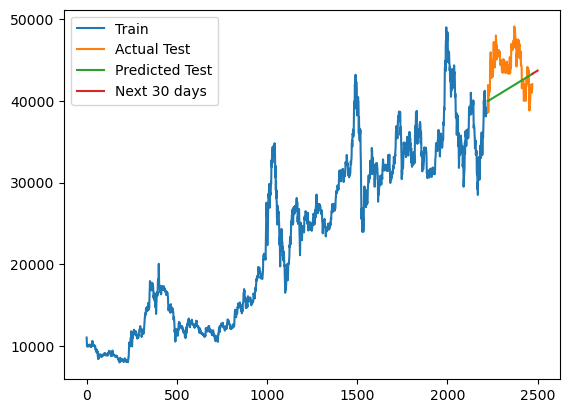

In [43]:
# Plot
plt.plot(df[:-train_size].index, df[:-train_size]['Price'], label='Train')
plt.plot(test.index, df[-train_size:]['Price'], label='Actual Test')
plt.plot(df[-train_size:].index, df_forecast['PriceForecast'], label='Predicted Test')
plt.plot(df_forecast_30.index, df_forecast_30['PriceForecast'], label='Next 30 days')
plt.legend()
plt.show()